<hr>
<div style = "background-color: black; text-align: center;padding:2px; padding-bottom:15px;color:white;">
<h1> Forecasting using Neural Networking | Outage Restoration </h1>

    Author: Mu Sigma
    
</div>

<hr>
<div style = "background-color: black; text-align: left;padding:2px; padding-bottom:15px;color:white;">
    <h3>Table of Content: <a id='importing_libraries'></a></h3>
</div>
<hr>

<a href='#importing_libraries'>1. Packages Used for Forecasting</a> <br>
<a href='#ads'>2. Extracting dataset and Other Transformations</a> <br>
<a href='#puhm'>3. Fitting model</a> <br>
<a href='#analysis'>4. Predicting model and comparison</a> <br>
<a href='#Iterations'>5. Other iterations</a> <br>
<a href='#hyper'>6. Hyperparameter Optimization for Keras</a> <br>
<a href='#conclusion'>7. Conclusion</a> <br>

<hr>
<div style = "background-color: black; text-align: left;padding:2px; padding-bottom:15px;color:white;">
    <h3>Executive Summary: <a id='importing_libraries'></a></h3>
</div>
<hr>

Deep Neural networking iteration performed:
1. Optimization using autokeras
2. Modified following parameters:<br>
    * Learning rate
    * Activator
    * Optimizer
    * batch size
    * epoch
    * hidden layer
    * nodes
Below is the best iteration got

<hr>
<div style = "background-color: black; text-align: center;padding:2px; padding-bottom:15px;color:white;">
    <h3>1. Packages Used for Forecasting <a id='importing_libraries'></a></h3>
</div>

<hr>

For neural networkig used __keras__ packages which is a minimalist Python library for deep learning that can run on top of Theano or TensorFlow. In our case Tensorflow is used. Other packages used are numpy, pandas and matplotlib

In [1]:
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import IPython.core.display as di
import seaborn as sns
from scipy import stats

#feature selection packages 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


#packages for neural networking
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.activations import relu, elu
import talos


plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Toggle Setup
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Using TensorFlow backend.


Toggle code

In [2]:
# Markdown Display
def printmd(string):
    display(Markdown(string))

<hr>
<div style = "background-color: black; text-align: center;padding:2px; padding-bottom:15px;color:white;">
    <h3> 2. Extracting Dataset and Other Transformations<a id='ads'></a></h3>
</div>
<hr>

##### 2.1 Extracting dataset
* filtering for only STORM events
* Dropping  null values 
* Dummification of categorical variables

In [3]:
#extracting data from the
df_ads = pd.read_csv('gs://aes-datahub-0001-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_DATASET_V8.2.csv')
df_storm = df_ads[df_ads.EVENT == 'STORM']

df_storm = pd.get_dummies(df_storm, columns=['ZONE','CITY_NAM','PRIM_CAUSE_DESC','DNI_EQUIP_TYPE','PRECIPTYPE','clusters','ICON','Marker_Location'])

df_storm = df_storm.drop(columns = ['Unnamed: 0','LAT','LONG','OUTAGE_ID','CIRCT_ID','INCIDENT_ID', 'EVENT','CREATION_DATETIME','ENERGIZED_DATETIME',
                                    'STRCTUR_NO','SUBST_ID', 'TERT_OCCURN_DESC',
                                    'SECO_CAUSE_DESC','DOWNSTREAM_KVA_VAL','ETR_DATETIME',
                                   'PRIM_OCCURN_DESC','SECO_OCCURN_DESC','UNIT'])

df_storm = df_storm.dropna()

print("Shape of the dataset",df_storm.shape)

Shape of the dataset (19514, 179)


##### 2.2 Splitting and transforming data into train and test
* Data is splitted into X and Y with X containing independent variables and Y as dependent variable (TTR)
* Independent variable is transformed using StandardScaler function
* Dependent variable (TTR) is transformed using log with base 10
* Size of the train and test split taken as 75:25

<hr>
<div style = "background-color: black; text-align: center;padding:2px; padding-bottom:15px;color:white;">
    <h3> Max Voting Regime <a id='ads'></a></h3>
</div>
<hr>

In [4]:
#################################################################################################################################################################################################################
############################################################################### FEATURE SELECTION : MAX VOTING REGIME ###########################################################################################


X = df_storm.drop(['TTR'],axis=1)
y = df_storm['TTR']

xg = xgb.XGBRegressor()
xg.fit(X,y)
rf = RandomForestRegressor()
rf.fit(X,y)
lg = lgb.LGBMRegressor()
lg.fit(X,y)
cb = cb.CatBoostRegressor(silent = True)
cb.fit(X,y)

xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)
rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
lightgbm = pd.DataFrame({'Features': X.columns, 'Importance_Score_Light_GBM': lg.feature_importances_}).sort_values(by='Importance_Score_Light_GBM',ascending=False)
catboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_CatBoost': cb.feature_importances_}).sort_values(by='Importance_Score_CatBoost',ascending=False)
xgboost.reset_index(drop=True,inplace=True)
rftrees.reset_index(drop=True,inplace=True)
lightgbm.reset_index(drop=True,inplace=True)
catboost.reset_index(drop=True,inplace=True)

xgboost = xgboost.head(30)
rftrees = rftrees.head(30)
lightgbm = lightgbm.head(30)
catboost = catboost.head(30)


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

final_features = do_union(list(xgboost.Features), list(rftrees.Features), list(lightgbm.Features), list(catboost.Features))
print(final_features)

[13:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
['DOWNSTREAM_CUST_QTY', 'clusters_6.0', 'PRESSURE', 'ZONE_4.0', 'WIRE_OCCURN_FLG', 'ICON_rain', 'PRIM_CAUSE_DESC_TREE', 'VISIBILITY', 'POWER_OUT_CLUE_FLG', 'PRECIPINTENSITY.1', 'HUMIDITY', 'LIVE_OUTAGE', 'RANK_SUBSEQUENT_OUTAGES', 'CUST_QTY', 'DAY_FLAG', 'POLE_CLUE_FLG', 'NEAREST-STATION', 'ZONE_3.0', 'POLE_OCCURN_FLG', 'DNI_EQUIP_TYPE_FUSE', 'Hour_Sin', 'TRANSFORMER_OCCURN_FLG', 'ICON_wind', 'PRECIPINTENSITY', 'DNI_EQUIP_TYPE_CUT', 'Min_Distance', 'DEWPOINT', 'WINDGUST', 'PRIORITY_VAL_2.0', 'clusters_7.0', 'KVA_VAL', 'TEMPERATUREMAX', 'WINDBEARING', 'CLOUDCOVER', 'TEMPERATUREMIN', 'CALL_QTY', 'ICON_snow', 'WINDSPEED']


In [6]:
features_df = df_storm[final_features]

X= features_df
Y=df_storm.TTR.values
sc= StandardScaler()
X= sc.fit_transform(X)
Y= Y.reshape(-1,1)
Y=np.log10(Y)

#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)


<hr>
<div style = "background-color: black; text-align: center;padding:2px; padding-bottom:15px;color:white;">
    <h3> 6. Hyperparameter Optimization for Keras  <a id='hyper'></a></h3>
</div>
<hr>

Used Talos for hyperparameter optimization. Here is the link for reference - [Talos](https://github.com/autonomio/talos)<br>
Parameter used:
* activation = relu
* number of hidden layer = 3
* optimizer = adam
* loss = mean_squared_error
* epochs = 100<br>

Parameter used for optimization:
* number of neuron = [4, 8, 12, 24, 48,64]
* batch_size = [20, 30, 50, 100] <br>

In total 432 combinations to run

In [22]:
p = {
    'first_neuron': [4, 8, 12, 24, 48],
    'second_neuron': [4, 8, 12, 24],
    'third_neuron': [4, 8, 12],
    'activation': ['relu'],
    'batch_size': [200, 500, 700]
}

# add input parameters to the function
def outage(x_train, y_train, x_val, y_val, params):
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(38, input_dim=38, activation=params['activation']))
    model.add(Dense(params['first_neuron'], activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # make sure history object is returned by model.fit()
    out = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=[X_test, y_test],
                    epochs=100,
                    batch_size=params['batch_size'],
                    verbose= False)
    
    # modify the output model
    return out, model


t = talos.Scan(x=X_train, y=y_train, x_val = X_test, y_val = y_test, params=p, model=outage, experiment_name='outage_neural')
talos.Deploy(scan_object=t, model_name='outage_neural_final', metric='accuracy');
outage = talos.Restore('outage_neural_final.zip')
# make predictions with the model
y_pred  = outage.model.predict(X_test)











  0%|          | 0/180 [00:00<?, ?it/s]









  1%|          | 1/180 [00:23<1:09:19, 23.24s/it]









  1%|          | 2/180 [00:45<1:07:50, 22.87s/it]









  2%|▏         | 3/180 [01:08<1:07:28, 22.87s/it]









  2%|▏         | 4/180 [01:33<1:08:58, 23.51s/it]









  3%|▎         | 5/180 [01:58<1:10:03, 24.02s/it]









  3%|▎         | 6/180 [02:24<1:11:21, 24.61s/it]









  4%|▍         | 7/180 [02:49<1:11:03, 24.64s/it]









  4%|▍         | 8/180 [03:15<1:12:31, 25.30s/it]









  5%|▌         | 9/180 [03:40<1:11:24, 25.06s/it]









  6%|▌         | 10/180 [04:02<1:08:34, 24.20s/it]









  6%|▌         | 11/180 [04:25<1:07:23, 23.93s/it]









  7%|▋         | 12/180 [04:51<1:08:13, 24.37s/it]









  7%|▋         | 13/180 [05:13<1:06:15, 23.81s/it]









  8%|▊         | 14/180 [05:36<1:04:43, 23.39s/it]









  8%|▊         | 15/180 [05:58<1:03:24, 23.06s/it]









  9%|▉         | 16/180 [06:21<1:02:50, 22.99s/it]

Deploy package outage_neural_final have been saved.


Predicting package and plotting output

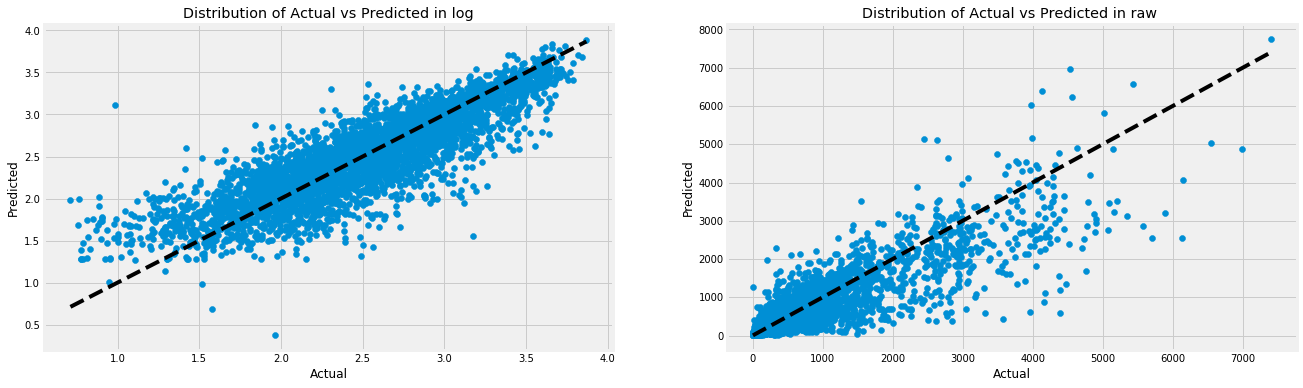

------------------------Forecast KPI--------------------------------------
MAPE for log transformed  11.0 %
MAPE without log transformed 66.0 %
RMSE without log transformed 491.0
MAE without log transformed 271.0 

------------------------Business KPI--------------------------------------
Below metrices are in count


prediction_segment,0-180,180-720,720-1440,1440-2160,2160-2880,2880-3600,3600-4320,4320-5040,5040-5760,5760-6480,6480-7200
Actual_segment,,,,,,,,,,,
0-180,87.2,10.9,1.7,0.1,0,nan,nan,nan,nan,nan,nan
180-720,36.2,43.8,18.8,1.2,nan,nan,nan,nan,nan,nan,nan
720-1440,11.6,28.6,46.1,12.8,0.9,nan,nan,nan,nan,nan,nan
1440-2160,4.1,13,32.5,39.4,9.3,1.6,nan,nan,nan,nan,nan
2160-2880,nan,7.6,15.9,29.7,31.7,12.4,0.7,0.7,1.4,nan,nan
2880-3600,nan,3.1,8.3,26,41.7,15.6,4.2,1,nan,nan,nan
3600-4320,nan,1.3,5.1,9,32.1,20.5,17.9,10.3,1.3,2.6,nan
4320-5040,nan,3.8,7.7,7.7,26.9,26.9,7.7,7.7,nan,7.7,3.8
5040-5760,nan,nan,nan,nan,33.3,44.4,nan,11.1,nan,nan,11.1


In [23]:
#plotting for log transformed value
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].scatter(y_test, y_pred)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
ax[0].set_title("Distribution of Actual vs Predicted in log")

#plotting for raw value
ax[1].scatter(np.power(10,y_test),np.power(10,y_pred) )
ax[1].plot([np.power(10,y_test).min(), np.power(10,y_test).max()], [np.power(10,y_test).min(), np.power(10,y_test).max()], 'k--', lw=4)
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')
ax[1].set_title("Distribution of Actual vs Predicted in raw ")
plt.show()


print("------------------------Forecast KPI--------------------------------------")
print("MAPE for log transformed ",round(np.mean(np.abs((y_test - y_pred)/y_test))*100),"%")
print("MAPE without log transformed",round(np.mean(np.abs((np.power(10,y_test) - np.power(10,y_pred))/np.power(10,y_test)))*100),"%")

print("RMSE without log transformed", round(np.sqrt(np.mean(np.power(np.power(10,y_test) - np.power(10,y_pred),2)))))
print("MAE without log transformed", round(np.mean(np.abs(np.power(10,y_test) - np.power(10,y_pred)))),"\n")

print("------------------------Business KPI--------------------------------------")

print("Below metrices are in count")
output = pd.DataFrame()
output['TTR_actual'] = np.reshape(np.power(10,y_test), (-1))
output['TTR_predicted'] = np.reshape(np.power(10,y_pred), (-1))
def segment(x):
    if(x<=360):
        return "0-180"
    elif(x<=720):
        return "180-720"
    elif(x<=1440):
        return "720-1440"
    elif(x<=2160):
        return "1440-2160"
    elif(x<=2880):
        return "2160-2880"
    elif(x<=3600):
        return "2880-3600"
    elif(x<=4320):
        return "3600-4320"
    elif(x<=5040):
        return "4320-5040"
    elif(x<=5760):
        return "5040-5760"
    elif(x<=6480):
        return "5760-6480"
    elif(x<=7200):
        return "6480-7200"
    else:
        return ">7200"
output['Actual_segment'] = output['TTR_actual'].apply(segment)
output['prediction_segment'] = output['TTR_predicted'].apply(segment)

business_KPI = output[['Actual_segment','prediction_segment']]

business_KPI['Actual_segment'] = pd.Categorical(business_KPI['Actual_segment'], ['0-180','180-720','720-1440','1440-2160', '2160-2880', '2880-3600', '3600-4320', 
                                                                   '4320-5040','5040-5760','5760-6480','6480-7200'])

business_KPI['prediction_segment'] = pd.Categorical(business_KPI['prediction_segment'], ['0-180','180-720','720-1440','1440-2160', '2160-2880', '2880-3600', '3600-4320', 
                                                                   '4320-5040','5040-5760','5760-6480','6480-7200','>7200'])

#conversion to percentage
business_KPI = pd.pivot_table(business_KPI, index='Actual_segment',columns=['prediction_segment'], values='Actual_segment', aggfunc=lambda x: len(x))
business_KPI.columns = business_KPI.columns.add_categories(['total'])
business_KPI["total"] =  business_KPI.sum(axis=1)
business_KPI = business_KPI.loc[:,:].div(business_KPI["total"], axis=0).multiply(100).round(1)
business_KPI = business_KPI.drop(columns = ['total'])

business_KPI.style.highlight_null(null_color='#25838e')

In [ ]:
sns.distplot(y_test, hist=False)

In [ ]:
sns.distplot(y_train, hist=False)

In [ ]:
output.to_csv("Actual_Predicted_Values_NN_Model.csv")